Materials in this notebook are adapted from Frank Burkholder and Ryan Henning. All IP property of Galvanize Inc.

## Demonstrate pdist and squareform

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist       # pair-wise distances
from scipy.spatial.distance import squareform  # dist. vector to square dist. matrix
from scipy.cluster.hierarchy import linkage    # how to define distances between clusters
from scipy.cluster.hierarchy import dendrogram # display a dendrogram 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = np.array([[-0.6, -1.0], [0.0, -0.8], [-1.5, -0.4],
                 [-1.4, -1.5], [1.1, -0.3], [-1.0, -1.1], 
                 [ 1.2,  0.0], [0.6, -0.3], [ 0.0,  0.7]])
labels = np.array(['1', '2', '3', '4', '5', '6', '7', '8', '9'])

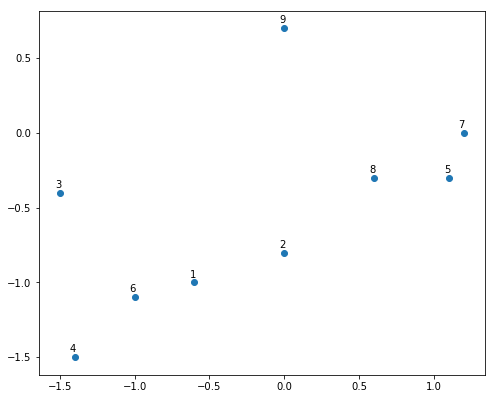

In [3]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
plt.scatter(data[:,0], data[:,1])

for label, x, y in zip(labels, data[:, 0], data[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-5, 5),
        textcoords='offset points')
ax.set_aspect('equal')
plt.show()

In [4]:
pairwise_distances = pdist(data)
print("Pair-wise distances")
print(pairwise_distances)
print("\nShape of pair-wise distances")
print(pairwise_distances.shape)

Pair-wise distances
[ 0.63245553  1.08166538  0.94339811  1.83847763  0.41231056  2.05912603
  1.3892444   1.80277564  1.55241747  1.56524758  1.2083046   1.04403065
  1.44222051  0.78102497  1.5         1.1045361   2.60192237  0.86023253
  2.72946881  2.1023796   1.86010752  2.77308492  0.56568542  3.0016662
  2.33238076  2.60768096  2.24722051  0.31622777  0.5         1.48660687
  2.45967478  1.78885438  2.05912603  0.67082039  1.3892444   1.16619038]

Shape of pair-wise distances
(36,)


In [5]:
pairwise_distances_squareform = squareform(pairwise_distances).round(2)
print("Squareform version of pair-wise distances")
print("     1      2    3     4     5     6     7     8     9")
for i, row in enumerate(pairwise_distances_squareform):
    print("{0} {1}".format(i+1,row))
print("\nShape of squareform version")
print(pairwise_distances_squareform.shape)

Squareform version of pair-wise distances
     1      2    3     4     5     6     7     8     9
1 [ 0.    0.63  1.08  0.94  1.84  0.41  2.06  1.39  1.8 ]
2 [ 0.63  0.    1.55  1.57  1.21  1.04  1.44  0.78  1.5 ]
3 [ 1.08  1.55  0.    1.1   2.6   0.86  2.73  2.1   1.86]
4 [ 0.94  1.57  1.1   0.    2.77  0.57  3.    2.33  2.61]
5 [ 1.84  1.21  2.6   2.77  0.    2.25  0.32  0.5   1.49]
6 [ 0.41  1.04  0.86  0.57  2.25  0.    2.46  1.79  2.06]
7 [ 2.06  1.44  2.73  3.    0.32  2.46  0.    0.67  1.39]
8 [ 1.39  0.78  2.1   2.33  0.5   1.79  0.67  0.    1.17]
9 [ 1.8   1.5   1.86  2.61  1.49  2.06  1.39  1.17  0.  ]

Shape of squareform version
(9, 9)


## Hierarchical Clustering Example

#### Functions to load and process the Churn Data

In [6]:
def recode(row_val):
    '''change categoricals from (0,1) to (-1.0, 1.0)'''
    return -1.0 if row_val == 0 else 1.0
        
def load_data(filename, standardize_cols):
    df = pd.read_csv(filename)

    # Binarize categoricals
    cols_categorical = ["Int'l Plan", "VMail Plan", "Churn?"]
    for col in cols_categorical:
        df[col] = (df[col] == 'yes').astype(int)
    
    # Drop some columns (arbitrary)
    del df['State']
    del df['Area Code']
    del df['Phone']
    del df['CustServ Calls']
    del df['Intl Mins']
    del df['VMail Message']

    # Standardize columns
    if standardize_cols:
        for col in df.columns.tolist():
            if col in cols_categorical:
                df[col] = df[col].apply(recode)
            else:
                df[col] = ((df[col] - df[col].mean())/df[col].std()).round(2)
            
    arr = df.values
    return arr, df.columns, df

## View data frame depending on standardization

In [7]:
# Set standardize columns flag
standardize_cols = True # Standardize columns (True) or not (False)

# Load data
arr, cols, df = load_data('data/churn.csv', standardize_cols)
df.head(5)

,Account Length,Int'l Plan,VMail Plan,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Calls,Intl Charge,Churn?
0,0.68,-1.0,1.0,1.57,0.48,1.57,-0.07,-0.06,-0.07,0.87,-0.47,0.87,-0.60,-0.09,-1.0
1,0.15,-1.0,1.0,-0.33,1.12,-0.33,-0.11,0.14,-0.11,1.06,0.15,1.06,-0.60,1.24,-1.0
2,0.90,-1.0,-1.0,1.17,0.68,1.17,-1.57,0.50,-1.57,-0.76,0.20,-0.76,0.21,0.70,-1.0
3,-0.43,1.0,-1.0,2.20,-1.47,2.20,-2.74,-0.61,-2.74,-0.08,-0.57,-0.08,1.02,-1.31,-1.0
4,-0.65,1.0,-1.0,-0.24,0.63,-0.24,-1.04,1.10,-1.04,-0.28,1.07,-0.28,-0.60,-0.05,-1.0


## Plot dendrogram

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


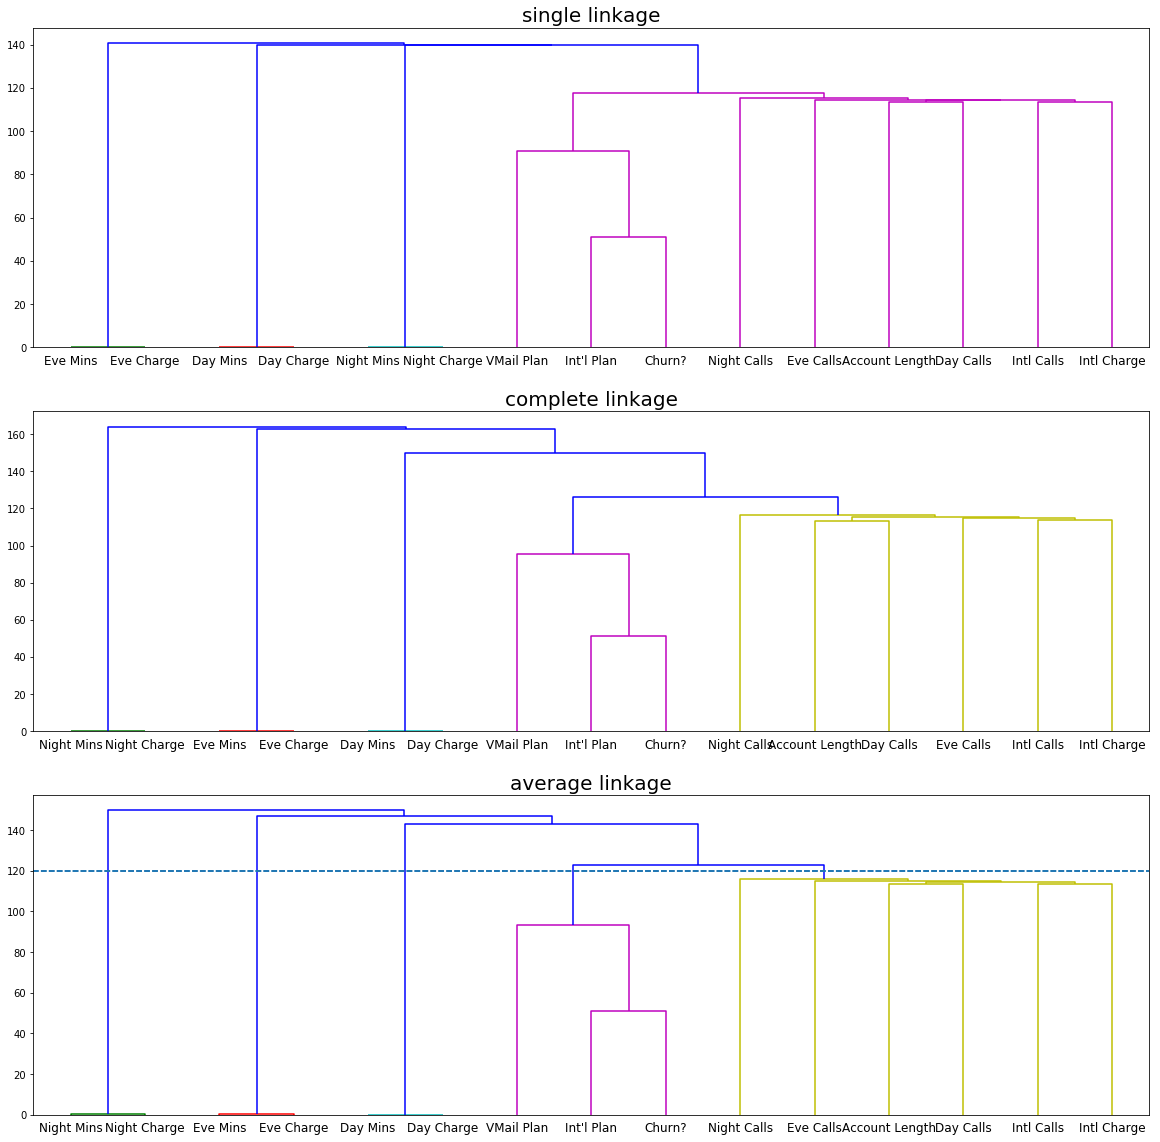

In [12]:
# Set distance metric
# see scipy.spatial.distance.pdist for options
distmetric = 'euclidean' # 'euclidean','cityblock','cosine' are some options

# Where would you like the clusters set?  In units of the dissimilarity metric
thresh = 120

# Find distances using pair-wise distances in the array, according to desired metric
dist = squareform(pdist(arr.transpose(), metric = distmetric))

# Plot dendrogram
fig, axarr = plt.subplots(nrows = 3, ncols = 1, figsize=(20, 20))
for ax, linkmethod in zip(axarr.flatten(), ['single', 'complete', 'average']):
    clust = linkage(dist, method=linkmethod)
    plt.axhline(120, linestyle='--')
    dendrogram(clust, ax=ax, labels=cols, color_threshold = thresh) #color threshold number sets the color change
    ax.set_title('{} linkage'.format(linkmethod), fontsize=20)
    plt.xticks(fontsize=12)
